In [3]:
from VariationalBayes import ScalarParam, ModelParamsDict, VectorParam, PosDefMatrixParam
from VariationalBayes.NormalParams import MVNParam, UVNParam, UVNParamVector
from VariationalBayes.GammaParams import GammaParam
from VariationalBayes.ExponentialFamilies import \
    UnivariateNormalEntropy, MultivariateNormalEntropy, GammaEntropy, \
    MVNPrior, UVNPrior, GammaPrior


from autograd import grad, hessian, jacobian, hessian_vector_product
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy as asp
import scipy as sp

import copy
from scipy import optimize

In [20]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.
import os
import json

prior_par = ModelParamsDict('Prior Parameters')

#analysis_name = 'simulated_data_small'
analysis_name = 'simulated_data_large'

data_dir = os.path.join(os.environ['GIT_REPO_LOC'], 'LRVBLogitGLMM/LogitGLMMLRVB/inst/data/')
json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)
json_output_filename = os.path.join(data_dir, '%s_python_vb_results.json' % analysis_name)

json_file = open(json_filename, 'r')
json_dat = json.load(json_file)
json_file.close()

stan_dat = json_dat['stan_dat']
vp_base = json_dat['vp_base']

print stan_dat.keys()
K = stan_dat['K'][0]
NObs = stan_dat['N'][0]
NG = stan_dat['NG'][0]
N = NObs / NG
y_g_vec = np.array(stan_dat['y_group'])
y_vec = np.array(stan_dat['y'])
x_mat = np.array(stan_dat['x'])

# Define a class to contain prior parameters.
prior_par.push_param(VectorParam('beta_prior_mean', K, val=np.array(stan_dat['beta_prior_mean'])))
beta_prior_info = np.linalg.inv(np.array(stan_dat['beta_prior_var']))
prior_par.push_param(PosDefMatrixParam('beta_prior_info', K, val=beta_prior_info))

prior_par.push_param(ScalarParam('mu_prior_mean', val=stan_dat['mu_prior_mean'][0]))
prior_par.push_param(ScalarParam('mu_prior_info', val=1 / stan_dat['mu_prior_var'][0]))

prior_par.push_param(ScalarParam('tau_prior_alpha', val=stan_dat['tau_prior_alpha'][0]))
prior_par.push_param(ScalarParam('tau_prior_beta', val=stan_dat['tau_prior_beta'][0]))

# An index set to make sure jacobians match the order expected by R.
prior_par_indices = copy.deepcopy(prior_par)
prior_par_indices.set_name('Prior Indices')
prior_par_indices.set_vector(np.array(range(prior_par_indices.vector_size())))


[u'y_group', u'mu_prior_var', u'mu_prior_t', u'mu_prior_var_c', u'K', u'beta_prior_var', u'tau_prior_beta', u'N', u'mu_prior_mean_c', u'mu_prior_epsilon', u'mu_prior_mean', u'y', u'x', u'NG', u'beta_prior_mean', u'tau_prior_alpha']


In [47]:
# Build an object to contain a variational approximation to a K-dimensional multivariate normal.
glmm_par = ModelParamsDict('GLMM Parameters')

glmm_par.push_param(ScalarParam('mu'))
glmm_par.push_param(ScalarParam('tau', lb=1e-6))
glmm_par.push_param(VectorParam('beta', K))
glmm_par.push_param(UVNParamVector('u', NG, min_info=vp_base['u_info_min'][0]))

# Initialize with ADVI.  Don't forget to add the ADVI computation time to your final VB time!
advi_fit = json_dat['advi_results']
glmm_par['mu'].set(advi_fit['mu_mean'][0])

tau_mean = advi_fit['tau_mean'][0]
glmm_par['tau'].set(tau_mean)

glmm_par['beta'].set(np.array(advi_fit['beta_mean']))

glmm_par['u'].mean.set(np.array(advi_fit['u_mean']))
glmm_par['u'].info.set(1 / np.array(advi_fit['u_var']))

free_par_vec = glmm_par.get_free()

In [48]:
# Define moment parameters

moment_par = ModelParamsDict('Moment Parameters')
moment_par.push_param(VectorParam('e_beta', K))
moment_par.push_param(PosDefMatrixParam('e_beta_outer', K))
moment_par.push_param(ScalarParam('e_mu'))
moment_par.push_param(ScalarParam('e_mu2'))
moment_par.push_param(ScalarParam('e_tau'))
moment_par.push_param(ScalarParam('e_log_tau'))
moment_par.push_param(VectorParam('e_u', NG))
moment_par.push_param(VectorParam('e_u2', NG))

def set_moments(glmm_par, moment_par):
    e_beta = glmm_par['beta'].get()
    moment_par['e_beta'].set(e_beta)
    moment_par['e_beta_outer'].set(np.outer(e_beta, e_beta))
    moment_par['e_mu'].set(glmm_par['mu'].get())
    moment_par['e_mu2'].set(glmm_par['mu'].get() ** 2)
    moment_par['e_tau'].set(glmm_par['tau'].get())
    moment_par['e_log_tau'].set(np.log(glmm_par['tau'].get()))
    moment_par['e_u'].set(glmm_par['u'].e())
    moment_par['e_u2'].set((glmm_par['u'].e_outer()))
    
set_moments(glmm_par, moment_par)

# Moment indices.
moment_indices = copy.deepcopy(moment_par)
moment_indices.set_vector(1 + np.array(range(moment_indices.vector_size())))

In [49]:
def decode_combined_parameters(combined_free_par_vec, glmm_par, prior_par):
    assert glmm_par.free_size() + prior_par.vector_size() == len(combined_free_par_vec) 
    glmm_par.set_free(combined_free_par_vec[0:glmm_par.free_size()])
    prior_par.set_vector(combined_free_par_vec[glmm_par.free_size():])

    
def encode_combined_parameters(glmm_par, prior_par):
    combined_free_par_vec = np.full(glmm_par.free_size() + prior_par.vector_size(), float('nan'))
    combined_free_par_vec[0:glmm_par.free_size()] = glmm_par.get_free()
    combined_free_par_vec[glmm_par.free_size():] = prior_par.get_vector()
    return combined_free_par_vec


In [53]:
np.zeros((2, 2))

array([[ 0.,  0.],
       [ 0.,  0.]])

In [54]:
def ELogPrior(prior_par, glmm_par_elbo):
    e_beta = glmm_par_elbo['beta'].get()
    cov_beta = np.zeros((len(e_beta), len(e_beta)))
    beta_prior_info = prior_par['beta_prior_info'].get()
    beta_prior_mean = prior_par['beta_prior_mean'].get()
    e_log_p_beta = MVNPrior(beta_prior_mean, beta_prior_info, e_beta, cov_beta)
    
    e_mu = glmm_par_elbo['mu'].get()
    mu_prior_mean = prior_par['mu_prior_mean'].get()
    mu_prior_info = prior_par['mu_prior_info'].get()
    e_log_p_mu = UVNPrior(mu_prior_mean, mu_prior_info, e_mu, 0.)

    e_tau = glmm_par_elbo['tau'].get()
    e_log_tau = np.log(e_tau)
    tau_prior_shape = prior_par['tau_prior_alpha'].get()
    tau_prior_rate = prior_par['tau_prior_beta'].get()
    e_log_p_tau = GammaPrior(tau_prior_shape, tau_prior_rate, e_tau, e_log_tau)
    
    return  e_log_p_beta + e_log_p_mu + e_log_p_tau
           

def DataLogLikelihood(x_mat, y_vec, e_beta, cov_beta, e_mu, var_mu, e_u, var_u, std_draws):
    z_mean = e_u + e_mu + np.matmul(x_mat, e_beta)
    z_sd = np.sqrt(var_u + var_mu + np.einsum('nk,kj,nj->n', x_mat, cov_beta, x_mat))
    z = np.einsum('i,j->ij', z_sd, std_draws) + np.expand_dims(z_mean, 1)

    # The sum is over observations and draws, so dividing by the draws size
    # gives the sum of sample expectations over the draws.
    # p = exp(z) / (1 + exp(z))
    # log(1 - p) = log(1 / (1 + exp(z))) = -log(1 + exp(z))
    logit_term = -np.sum(np.log1p(np.exp(z))) / std_draws.size
    y_term = np.sum(y_vec * z_mean)
    return y_term + logit_term


def RandomEffectLogLikelihood(e_u, var_u, e_tau, e_log_tau):
    return -0.5 * e_tau * np.sum((e_u ** 2) + var_u) + 0.5 * e_log_tau * len(e_u)

    
def Elbo(y_vec, x_mat, y_g_vec, glmm_par_elbo, std_draws, prior_par):
    e_beta = glmm_par_elbo['beta'].get()
    cov_beta = np.zeros((len(e_beta), len(e_beta)))
    
    e_u = glmm_par_elbo['u'].mean.get()
    info_u = glmm_par_elbo['u'].info.get()
    var_u = 1 / info_u
    
    e_mu = glmm_par_elbo['mu'].get()
    var_mu = 0.
    
    e_tau = glmm_par_elbo['tau'].get()
    e_log_tau = np.log(e_tau)
        
    ll = \
        DataLogLikelihood(x_mat, y_vec, e_beta, cov_beta, e_mu, var_mu,
                          e_u[y_g_vec], var_u[y_g_vec], std_draws) + \
        RandomEffectLogLikelihood(e_u, var_u, e_tau, e_log_tau)
    if np.isnan(ll):
        return -np.inf

    e_log_prior = ELogPrior(prior_par, glmm_par_elbo)
    if np.isnan(e_log_prior):
        return -np.inf
    
    entropy = UnivariateNormalEntropy(info_u)

    return ll[0] + e_log_prior[0] + entropy


class KLWrapper(object):
    def __init__(self, glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_draws):
        self.__glmm_par_ad = copy.deepcopy(glmm_par)
        self.__prior_par_ad = copy.deepcopy(prior_par)
        self.x_mat = x_mat
        self.y_vec = y_vec
        self.y_g_vec = y_g_vec
        draw_spacing = 1 / float(num_draws + 1)
        target_quantiles = np.linspace(draw_spacing, 1 - draw_spacing, num_draws)
        self.std_draws = sp.stats.norm.ppf(target_quantiles)

    def Eval(self, free_par_vec, verbose=False):
        self.__glmm_par_ad.set_free(free_par_vec)
        kl = -Elbo(self.y_vec, self.x_mat, self.y_g_vec,
                   self.__glmm_par_ad, self.std_draws, self.__prior_par_ad)
        if verbose: print kl
            
        # TODO: this is returning an array when it should be a scalar.
        return kl
    
    def ExpectedLogPrior(self, combined_free_par_vec):
        # Encode the glmm parameters first and the prior second.
        decode_combined_parameters(combined_free_par_vec, self.__glmm_par_ad, self.__prior_par_ad)
        e_log_prior = ELogPrior(self.__prior_par_ad, self.__glmm_par_ad)
        return e_log_prior[0]
        

class MomentWrapper(object):
    def __init__(self, glmm_par, moment_par):
        self.__glmm_par_ad = copy.deepcopy(glmm_par)
        self.__moment_par = copy.deepcopy(moment_par)

    # Return a posterior moment of interest as a function of unconstrained parameters.
    def GetMoments(self, free_par_vec):
        self.__glmm_par_ad.set_free(free_par_vec)
        set_moments(self.__glmm_par_ad, self.__moment_par)
        return self.__moment_par.get_vector()
    
    def GetMomentParameters(self, free_par_vec):
        self.__glmm_par_ad.set_free(free_par_vec)
        set_moments(self.__glmm_par_ad, self.__moment_par)
        return self.__moment_par


kl_wrapper = KLWrapper(glmm_par, prior_par, x_mat, y_vec, y_g_vec, 10)
KLGrad = grad(kl_wrapper.Eval)
KLHess = hessian(kl_wrapper.Eval)
KLHessVecProd = hessian_vector_product(kl_wrapper.Eval)  
print kl_wrapper.Eval(free_par_vec)

moment_wrapper = MomentWrapper(glmm_par, moment_par)
MomentJacobian = jacobian(moment_wrapper.GetMoments)

combined_free_par_vec = encode_combined_parameters(glmm_par, prior_par)
PriorHess = hessian(kl_wrapper.ExpectedLogPrior)
kl_wrapper.ExpectedLogPrior(combined_free_par_vec)


95.1426052729


-10.75183151989394

In [110]:
import timeit

time_num = 10

print 'Function time:'
print timeit.timeit(lambda: kl_wrapper.Eval(free_par_vec), number=time_num) / time_num

print 'Grad time:'
print timeit.timeit(lambda: KLGrad(free_par_vec), number=time_num) / time_num

print 'Hessian vector product time:'
print timeit.timeit(lambda: KLHessVecProd(free_par_vec, free_par_vec + 1), number=time_num) / time_num

# print 'Moment jacobian time:'
# print timeit.timeit(lambda: MomentJacobian(free_par_vec), number=time_num) / time_num

# time_num = 1
# print 'Prior Hessian time:'
# print timeit.timeit(lambda: PriorHess(combined_free_par_vec), number=time_num) / time_num

# # so slow
# print 'Hessian time:'
# print timeit.timeit(lambda: KLHess(free_par_vec), number=time_num) / time_num


Function time:
0.0243091106415
Grad time:
0.0332554101944
Hessian vector product time:
0.054833316803


In [60]:
import time

class OptimizationPath(object):
    def __init__(self):
        self.x_history = []
        pass
    
    def save(self, x):
        self.x_history.append(x)

bfgs_path = OptimizationPath()
init_par_vec = copy.deepcopy(free_par_vec)

# Optimize.
vb_time = time.time()
# print 'Running BFGS'
# vb_opt_bfgs = optimize.minimize(
#     lambda par: kl_wrapper.Eval(par, verbose=True), init_par_vec,
#     method='bfgs', jac=KLGrad, tol=1e-2, callback=bfgs_path.save,
#     options={'maxiter': 100, 'gtol': 1e-2, 'disp': True})

trust_path = OptimizationPath()
print 'Running Newton Trust Region'
# trust_init = copy.deepcopy(vb_opt_bfgs.x)
trust_init = copy.deepcopy(init_par_vec)
vb_opt = optimize.minimize(
    lambda par: kl_wrapper.Eval(par, verbose=True),
    trust_init, method='trust-ncg', jac=KLGrad, hessp=KLHessVecProd,
    tol=1e-6, callback=trust_path.save, options={'maxiter': 500, 'disp': True, 'gtol': 1e-6 })

vb_time = time.time() - vb_time

glmm_par_opt = copy.deepcopy(glmm_par)
glmm_par_opt.set_free(vb_opt.x)

print 'Done.'

print vb_time / 60

Running Newton Trust Region
95.1426052729
-112.391028651
-146.808463208
-171.469919433
-173.019081886
-186.84845812
-216.995205816
-266.351102232
-280.725573343
-335.596294363
-338.549466136
-346.146324763
-355.155762228
-355.400176214
-356.087381267
-357.809516554
-358.52957125
-359.791118993
-359.841615734
-359.863732765
-359.88287169
-362.330786245
-363.751275411
-363.788489883
-363.803927573
-363.816029901
-363.826979041
-363.853368073
-363.868588518
-363.88054049
-363.89083391
-363.900108391
-363.932927098
-363.949438813
-363.962642966
-363.973879208
-363.983936594
-363.993311914
-364.002332863
-364.011214641
-364.028608875
-364.039858727
-364.049026191
-364.057135214
-364.075009794
-364.086905863
-364.096635352
-364.105338768
-364.113569712
-364.121618058
-364.12957813
-364.146578856
-364.157267224
-364.166140615
-364.174231323
-364.181996541
-364.189560998
-364.206313978
-364.216813881
-364.225543802
-364.233503134
-364.241156726
-364.248700754
-364.264700135
-364.274892661
-364

In [77]:
print len(trust_path.x_history)

# for i in range(len(path.x_history) - 1):
#     print np.sum(path.x_history[i + 1] - path.x_history[i])
    
# for i in range(len(trust_path.x_history)):
#     glmm_par.set_free(trust_path.x_history[i])
#     #print 'Iteration ' + str(i) + '\n'
#     #print str(np.diag(glmm_par['beta'].info.get())) + '\n'
#     #print str(np.diag(glmm_par['mu'].get())) + '\n'
#     #print str(glmm_par['beta'].get()[2]) + '\n'

vals = [ kl_wrapper.Eval(x) for x in trust_path.x_history ]

# for i in range(len(trust_path.x_history)):
    #grad = KLGrad(trust_path.x_history[i])
    #print np.max(np.abs(grad))

print vals



500
[-112.39102865076472, -146.80846320792955, -171.46991943324167, -173.01908188570519, -186.8484581196002, -216.99520581581214, -266.35110223216839, -280.72557334277974, -335.59629436282478, -338.54946613647189, -346.14632476309055, -355.15576222825166, -355.40017621370919, -355.40017621370919, -357.80951655432671, -358.52957125032231, -359.79111899257703, -359.84161573395681, -359.86373276546499, -359.88287169014257, -362.33078624493157, -363.75127541128796, -363.78848988252156, -363.80392757329264, -363.8160299011933, -363.82697904120488, -363.85336807250252, -363.86858851754749, -363.88054048967507, -363.89083390982188, -363.90010839139705, -363.93292709844246, -363.94943881270314, -363.96264296598468, -363.97387920781676, -363.98393659370646, -363.99331191412443, -364.00233286277199, -364.01121464057172, -364.02860887523462, -364.03985872691305, -364.04902619090853, -364.05713521432818, -364.0750097942497, -364.08690586257268, -364.09663535157813, -364.1053387678308, -364.1135697

In [64]:
hess = KLHess(vb_opt.x)

In [91]:
vals, vecs = np.linalg.eig(hess)
grad = KLGrad(vb_opt.x)
step_direction = -np.linalg.solve(hess, grad)

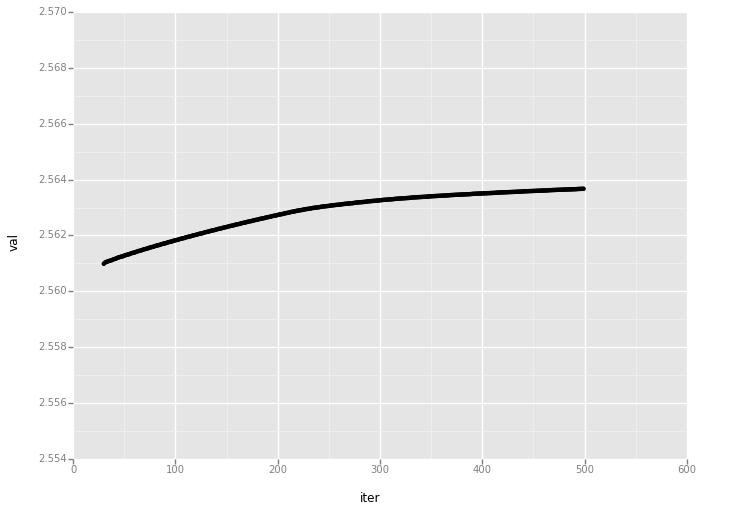

<ggplot: (8748116101273)>


In [84]:
# Check the random effect estimates.  This requires simulated data.
from ggplot import *
import pandas as pd
%matplotlib inline

plot_df = pd.DataFrame({ 'iter': np.arange(len(vals)), 'val': np.log10(np.abs(vals)) })
print ggplot(plot_df[30:], aes(x='iter', y='val')) + geom_point()



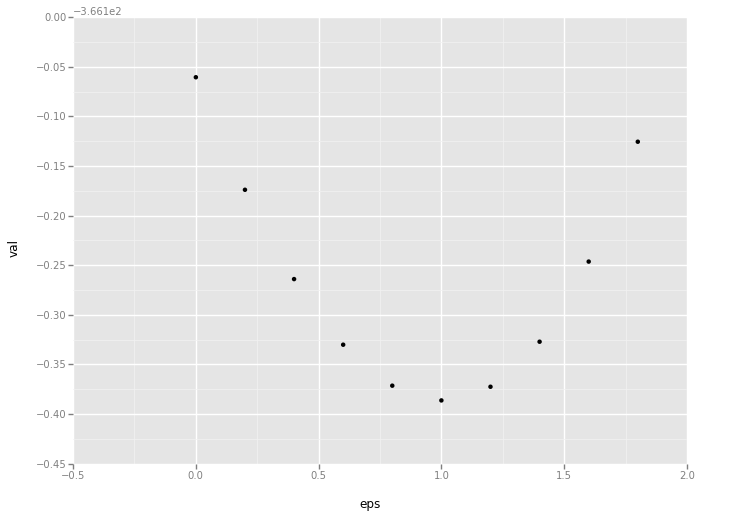

<ggplot: (8748149465853)>


In [112]:
max_eps = 2.
eps_vals = np.arange(0., max_eps, max_eps / 10)
kl_steps = [ kl_wrapper.Eval(vb_opt.x + eps * step_direction) for eps in eps_vals ]
plot_df = pd.DataFrame({ 'eps': eps_vals, 'val': kl_steps })
print ggplot(plot_df, aes(x='eps', y='val')) + geom_point()



# glmm_par.set_free(step_direction / np.linalg.norm(step_direction))
# min_vec = vecs[:, vals.argmin()]
# glmm_par.set_free(min_vec)
# print glmm_par

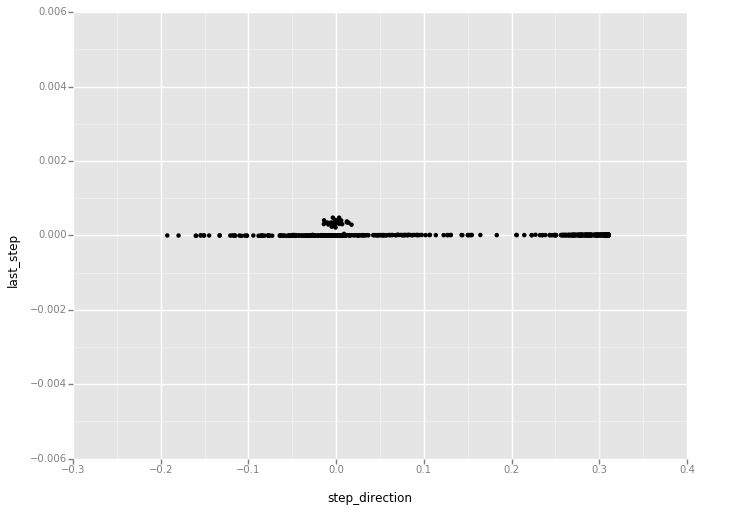

<ggplot: (8748149408425)>
0.241480038948
0.0681596884129


In [126]:
last_step = trust_path.x_history[len(trust_path.x_history) - 1] - trust_path.x_history[len(trust_path.x_history) - 2]
plot_df = pd.DataFrame({ 'last_step': last_step, 'step_direction': step_direction })
print ggplot(plot_df, aes(x='step_direction', y='last_step')) + geom_point()
print np.sum(np.abs(last_step) < 1e-6) / float(len(last_step))
print np.sum(np.abs(step_direction) < 1e-6) / float(len(step_direction))


In [85]:
# Slow, but probably faster than using CG.
combined_free_par_vec = encode_combined_parameters(glmm_par_opt, prior_par)

hess_time = time.time()
print 'KL Hessian.\n'
kl_hess = KLHess(vb_opt.x)
print 'Log prior Hessian.\n'
log_prior_hess_full = PriorHess(combined_free_par_vec)
hess_time =  time.time() - hess_time
elbo_hess = -kl_hess

print 'hess_time: %f' % hess_time

KL Hessian:

Log prior Hessian:

hess_time: 16.464133


In [86]:
glmm_inds = range(glmm_par_opt.free_size())
prior_inds = range(glmm_par_opt.free_size(), len(combined_free_par_vec))
log_prior_hess = log_prior_hess_full[np.ix_(prior_inds, glmm_inds)]

moment_jac = MomentJacobian(vb_opt.x)
lrvb_cov = np.matmul(moment_jac, np.linalg.solve(kl_hess, moment_jac.T))

prior_indices = copy.deepcopy(prior_par)
prior_indices.set_vector(1 + np.array(range(prior_indices.vector_size())))

vp_indices = copy.deepcopy(glmm_par_opt)
vp_indices.set_vector(1 + np.array(range(vp_indices.vector_size())))

In [87]:
run_name = 'debug'
result_dict = { 'glmm_par_opt': glmm_par_opt.dictval(), 'run_name': run_name,
                'vb_time': vb_time,'hess_time': hess_time, 
                'moment_indices': moment_indices.dictval(),
                'prior_indices': prior_indices.dictval(),
                'vp_indices': vp_indices.dictval(),
                'lrvb_cov': lrvb_cov.tolist(), 'moment_jac': moment_jac.tolist(),
                'elbo_hess': elbo_hess.tolist(), 'log_prior_hess': log_prior_hess.tolist() }

result_json = json.dumps(result_dict)
json_file = open(json_output_filename, 'w')
json_file.write(result_json)
json_file.close()

print(json_output_filename)

/home/rgiordan/Documents/git_repos/LRVBLogitGLMM/LogitGLMMLRVB/inst/data/simulated_data_large_python_vb_results.json
